# **Artificial Neural Networks and Deep Learning**

---

## **Lecture 7: Transfer Learning and Fine-Tuning**

<img src="https://drive.google.com/uc?export=view&id=1gsJ4h701PWou3B_JsjbfhIZnefsn2mGN" width="500"/>

## 🌐 **Google Drive Connection**

In [1]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/Colab\\ Notebooks/[2025-2026]\\ AN2DL/Lecture\\ 7"
%cd $current_dir

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/Lecture 7


## ⚙️ **Libraries Import**

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import InterpolationMode
!pip install torchview
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [3]:
def load_oxford_pets():
    """
    Load Oxford-IIIT Pet dataset, resize to 128x128.
    Optimized: Uses batch loading to fill a pre-allocated tensor, avoiding IPC freeze.
    """
    from torchvision.datasets import OxfordIIITPet
    from torchvision.transforms import InterpolationMode
    import math

    # Define transforms: Resize to 128x128, convert to Float Tensor
    transform = transforms.Compose([
        transforms.ToImage(),
        transforms.Resize((128, 128), antialias=True),
        transforms.ToDtype(torch.float32, scale=True)
    ])

    # Initialize datasets
    train_dataset = OxfordIIITPet(root='./data', split='trainval', download=True, transform=transform)
    test_dataset = OxfordIIITPet(root='./data', split='test', download=True, transform=transform)

    # Helper function to load dataset into a pre-allocated tensor
    def fill_dataset(dataset, batch_size=512):
        n_samples = len(dataset)
        # Pre-allocate memory (N, 3, 128, 128)
        X = torch.zeros((n_samples, 3, 128, 128), dtype=torch.float32)
        y = torch.zeros(n_samples, dtype=torch.int64)

        # Use multiple workers for parallel resizing
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                            num_workers=os.cpu_count() or 2)

        print(f"Loading {n_samples} images with {loader.num_workers} workers...")

        start_idx = 0
        for batch_x, batch_y in loader:
            end_idx = start_idx + batch_x.shape[0]
            X[start_idx:end_idx] = batch_x
            y[start_idx:end_idx] = batch_y
            start_idx = end_idx

        return X, y

    # Load training data
    print("Processing Training Data...")
    X_train_tensor, y_train_tensor = fill_dataset(train_dataset)

    # Load test data
    print("Processing Test Data...")
    X_test_tensor, y_test_tensor = fill_dataset(test_dataset)

    # Get class names
    class_names = [name.lower() for name in train_dataset.classes]

    # Convert to NumPy (fast operation on CPU tensors)
    return (X_train_tensor.numpy(), y_train_tensor.numpy()), \
           (X_test_tensor.numpy(), y_test_tensor.numpy()), \
           class_names

# Execute loading
(X_train, y_train), (X_test, y_test), class_names = load_oxford_pets()

# Display shapes
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print(f"Number of classes: {len(class_names)}")

Processing Training Data...
Loading 3680 images with 2 workers...
Processing Test Data...
Loading 3669 images with 2 workers...

Training set shape: (3680, 3, 128, 128)
Test set shape: (3669, 3, 128, 128)
Number of classes: 37


## 🔎 **Data Exploration**

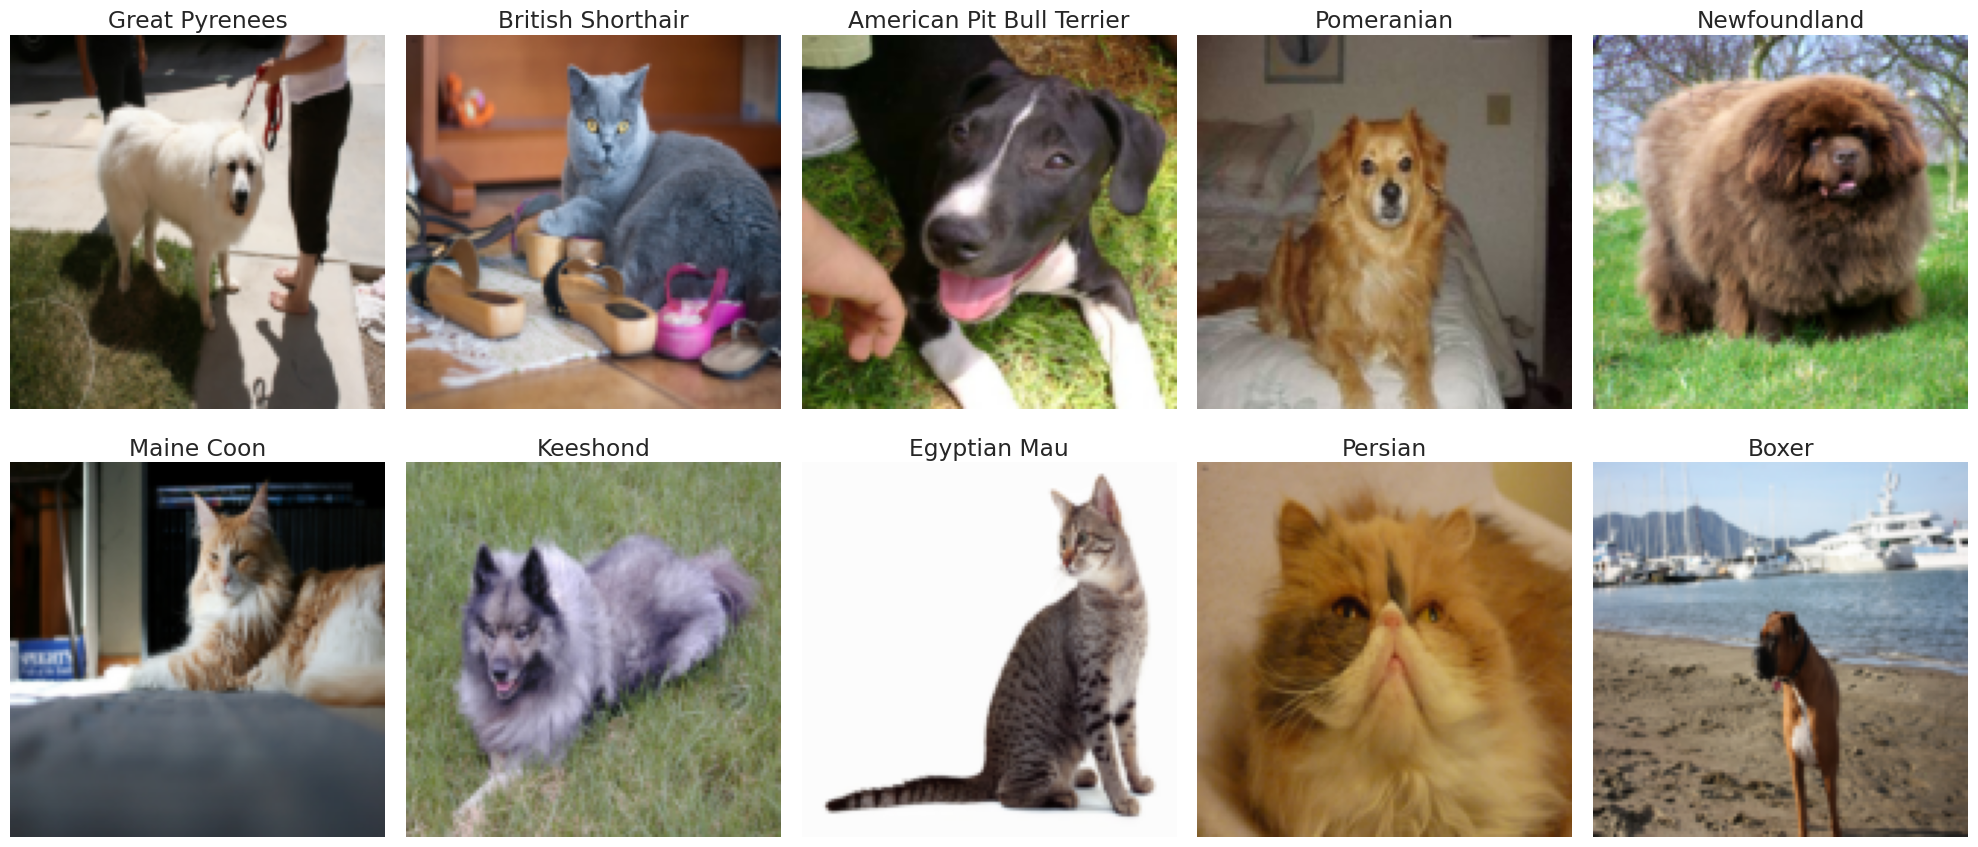

In [4]:
# Number of images to display
num_img = 10

# Select random indices from the training set
random_indices = random.sample(range(len(X_train)), num_img)

# Create subplot layout for images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Display the image at the selected index (convert CHW to HWC)
    img = X_train[idx].transpose(1, 2, 0)
    ax.imshow(img)

    # Add class name as title
    class_name = class_names[y_train[idx]]
    class_name = class_name.replace('_', ' ').title()
    ax.set_title(class_name, pad=5)

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

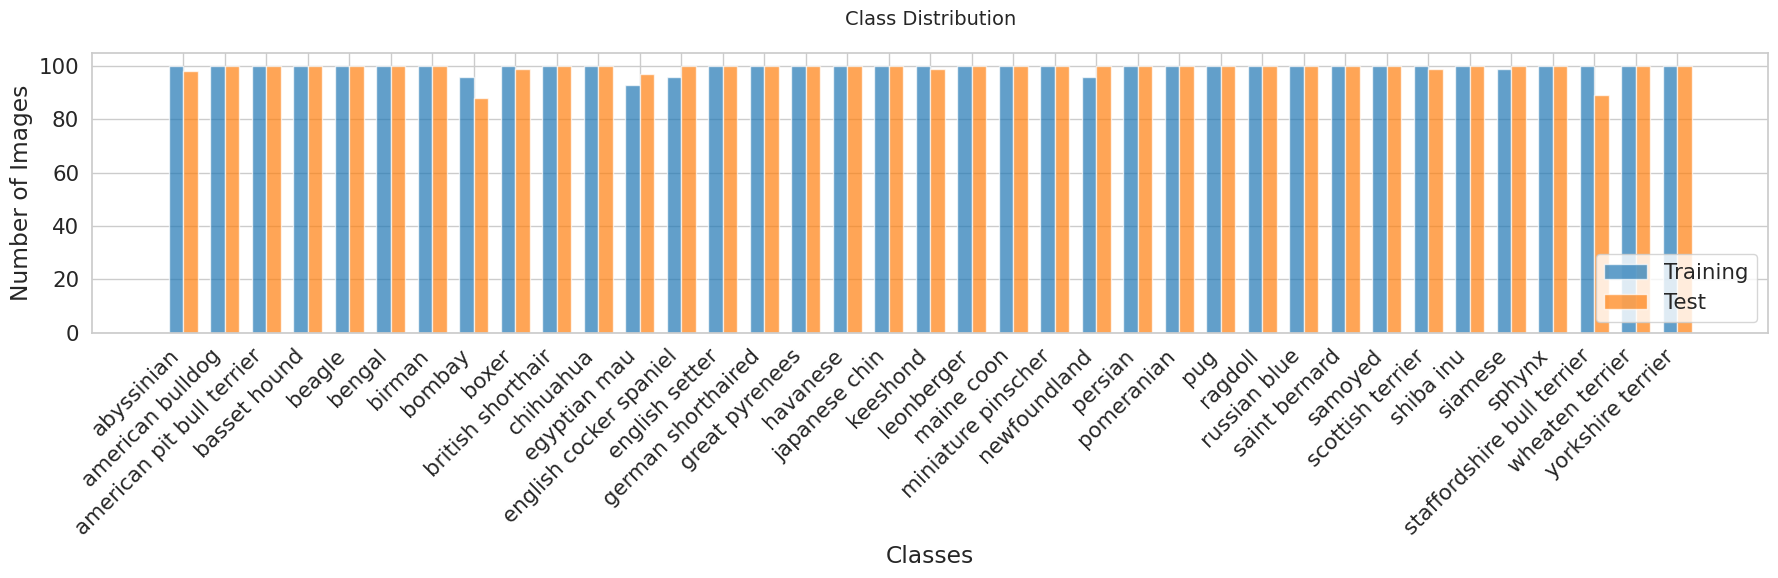

In [5]:
def plot_class_distribution(y_train, y_test, class_names):
    """Plot class distribution for training and test sets."""
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Calculate class distributions for training and test sets
    train_dist = np.bincount(y_train)
    test_dist = np.bincount(y_test)

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#1f77b4', alpha=0.7)
    plt.bar(x + width / 2, test_dist, width, label='Test', color='#ff7f0e', alpha=0.7)

    # Customize plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# Execute function to plot class distribution
plot_class_distribution(y_train, y_test, class_names)

##  📄 **Data Preprocessing**

In [6]:
# Split test set into validation and test sets with stratification
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, random_state=SEED, test_size=0.5, stratify=y_test
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3680, 3, 128, 128), y_train shape: (3680,)
X_val shape: (1834, 3, 128, 128), y_val shape: (1834,)
X_test shape: (1835, 3, 128, 128), y_test shape: (1835,)


In [7]:
# Define the input shape and number of classes
input_shape = (3, 128, 128)
num_classes = len(class_names)

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 128, 128)
Number of Classes: 37


In [8]:
# Define the batch size
BATCH_SIZE = 64

In [9]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


class PetsDataset(torch.utils.data.Dataset):
    """Custom PyTorch Dataset for Oxford Pets with optional augmentation and normalization."""

    def __init__(self, data, labels, augmentation=None, normalize_imagenet=False):
        """
        Args:
            data: numpy array of images (N, C, H, W) in range [0, 1]
            labels: numpy array of labels
            augmentation: transforms for data augmentation
            normalize_imagenet: whether to apply ImageNet normalization
        """
        self.data = torch.from_numpy(data)
        self.labels = torch.from_numpy(labels).long()
        self.augmentation = augmentation
        self.normalize_imagenet = normalize_imagenet

        # ImageNet normalization transform
        if normalize_imagenet:
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        else:
            self.normalize = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].clone()  # Clone to avoid modifying original
        label = self.labels[idx]

        # Apply augmentation if provided (on images in [0, 1] range)
        if self.augmentation:
            image = self.augmentation(image)

        # Apply ImageNet normalization if requested
        if self.normalize:
            image = self.normalize(image)

        return image, label

In [10]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """Create a PyTorch DataLoader with optimized settings."""
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,
    )

##  🧮 **Network Parameters**

In [11]:
# Training parameters
LEARNING_RATE = 1e-3
EPOCHS = 200
PATIENCE = 20

# Regularization
DROPOUT_RATE = 0.3

# Set up loss function
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)

Epochs: 200
Batch Size: 64
Learning Rate: 0.001
Dropout Rate: 0.3
Patience: 20


##  🧠 **Training Functions**

In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_acc


def validate_one_epoch(model, val_loader, criterion, device):
    """Validate for one epoch."""
    model.eval()

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = accuracy_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions)
    )

    return epoch_loss, epoch_accuracy


def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        patience=0, evaluation_metric="val_acc", mode='max',
        restore_best_weights=True, writer=None, verbose=1, experiment_name=""):
    """Train the neural network model."""

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        val_loss, val_acc = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_acc'].append(val_acc)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('Accuracy/Training', train_acc, epoch)
            writer.add_scalar('Accuracy/Validation', val_acc, epoch)

        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
                    f"Val: Loss={val_loss:.4f}, Acc={val_acc:.4f}")

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    if writer is not None:
        writer.close()

    return model, training_history

##  🛠️ **Train EfficientNetB0 from Scratch**

In [13]:
class EfficientNetB0FromScratch(nn.Module):
    """EfficientNet-B0 trained from scratch (Random weights)."""

    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()

        # Load architecture with NO pretrained weights
        self.backbone = torchvision.models.efficientnet_b0(weights=None)

        # Re-build classifier head
        # EfficientNet classifier is a Sequential; the Linear layer is the last one [-1]
        in_features = self.backbone.classifier[-1].in_features

        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]             512
      BatchNorm2d-14           [-1, 16,

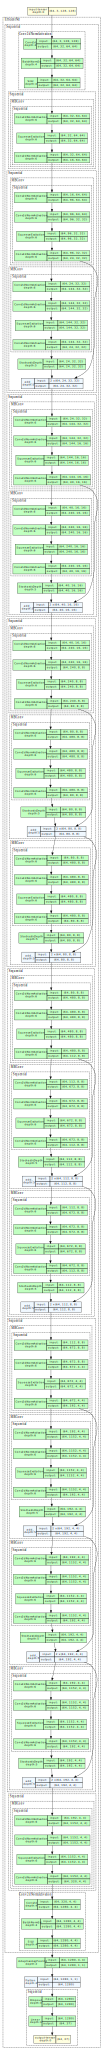

In [14]:
# Initialize model
scratch_model = EfficientNetB0FromScratch(num_classes, DROPOUT_RATE).to(device)

# Visualize structure
summary(scratch_model, input_size=input_shape)
model_graph = draw_graph(scratch_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
model_graph.visual_graph

In [15]:
# Define augmentation for training
train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2))
])

# Create datasets WITHOUT ImageNet normalization (training from scratch)
train_scratch_ds = PetsDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=True)
val_scratch_ds = PetsDataset(X_val, y_val, augmentation=None, normalize_imagenet=True)

train_scratch_loader = make_loader(train_scratch_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_scratch_loader = make_loader(val_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

In [16]:
# Setup Training
experiment_name = "from_scratch"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
optimizer = torch.optim.Adam(scratch_model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [17]:
%%time
# Train model from scratch
scratch_model, scratch_history = fit(
    model=scratch_model,
    train_loader=train_scratch_loader,
    val_loader=val_scratch_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_acc = round(max(scratch_history['val_acc']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc}%')

Training 200 epochs...
Epoch   1/200 | Train: Loss=3.6942, Acc=0.0307 | Val: Loss=3.6198, Acc=0.0273
Epoch   5/200 | Train: Loss=3.3752, Acc=0.0791 | Val: Loss=3.4565, Acc=0.0747
Epoch  10/200 | Train: Loss=3.0127, Acc=0.1524 | Val: Loss=2.9771, Acc=0.1609
Epoch  15/200 | Train: Loss=2.6453, Acc=0.2315 | Val: Loss=2.7085, Acc=0.2116
Epoch  20/200 | Train: Loss=2.2969, Acc=0.3217 | Val: Loss=2.4863, Acc=0.2841
Epoch  25/200 | Train: Loss=1.9856, Acc=0.4008 | Val: Loss=2.4090, Acc=0.3261
Epoch  30/200 | Train: Loss=1.7364, Acc=0.4630 | Val: Loss=2.2829, Acc=0.3691
Epoch  35/200 | Train: Loss=1.5130, Acc=0.5239 | Val: Loss=2.2248, Acc=0.4144
Epoch  40/200 | Train: Loss=1.2899, Acc=0.5864 | Val: Loss=2.2567, Acc=0.4400
Epoch  45/200 | Train: Loss=1.1526, Acc=0.6250 | Val: Loss=2.2504, Acc=0.4498
Epoch  50/200 | Train: Loss=0.9553, Acc=0.6935 | Val: Loss=2.3338, Acc=0.4629
Epoch  55/200 | Train: Loss=0.8319, Acc=0.7473 | Val: Loss=2.2719, Acc=0.4782
Epoch  60/200 | Train: Loss=0.6949, Acc=0

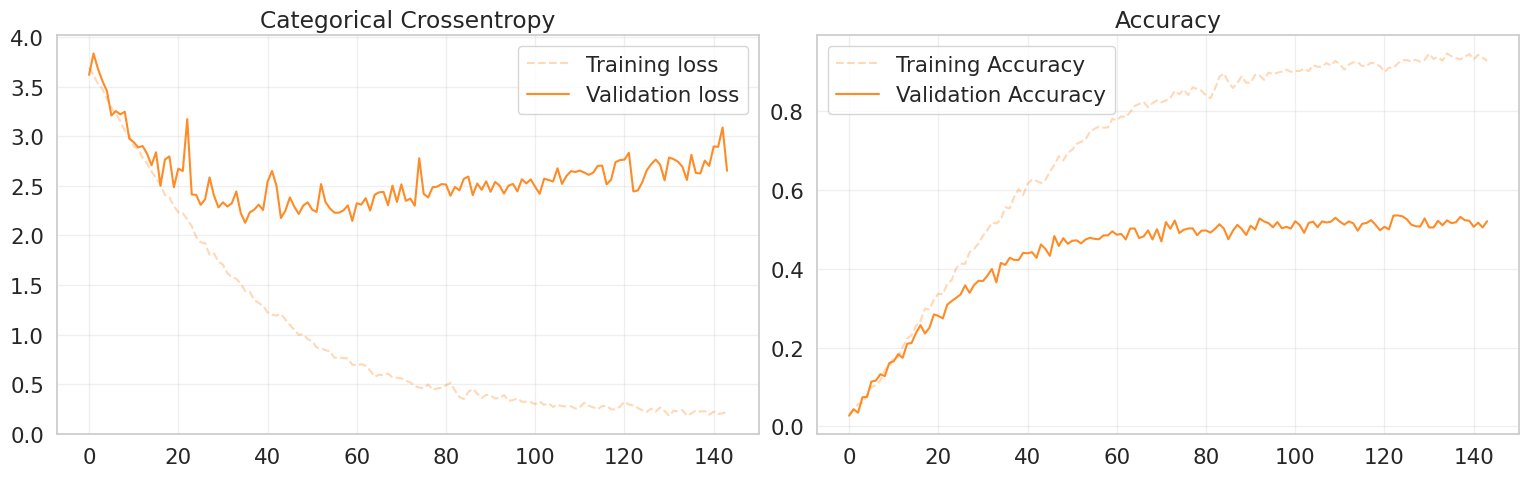

In [18]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(scratch_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(scratch_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(scratch_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(scratch_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#ff7f0e')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

## 🛠️ **Transfer Learning**

In [19]:
class EfficientNetB0TransferLearning(nn.Module):
    """EfficientNet-B0 with ImageNet pretrained weights."""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # Load weights pretrained on ImageNet
        self.backbone = torchvision.models.efficientnet_b0(
            weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
        )

        # Freeze the backbone layers (features)
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # Replace classifier (Always trainable)
        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              SiLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              SiLU-6           [-1, 32, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]             512
      BatchNorm2d-14           [-1, 16,

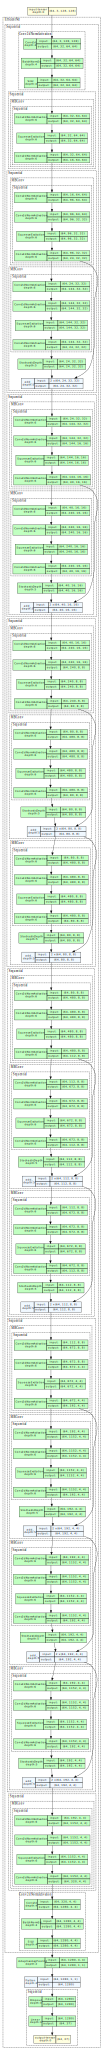

In [20]:
# Create transfer learning model
tl_model = EfficientNetB0TransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)

# Display model summary
summary(tl_model, input_size=input_shape)
model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
model_graph.visual_graph

In [21]:
# Create datasets WITH ImageNet normalization (for pretrained model)
train_tl_ds = PetsDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=True)
val_tl_ds = PetsDataset(X_val, y_val, augmentation=None, normalize_imagenet=True)

train_tl_loader = make_loader(train_tl_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_tl_loader = make_loader(val_tl_ds, BATCH_SIZE, shuffle=False, drop_last=False)

In [22]:
# Setup training
experiment_name = "transfer_learning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
optimizer = torch.optim.Adam(tl_model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [23]:
%%time
# Train with transfer learning
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_tl_loader,
    val_loader=val_tl_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_acc = round(max(tl_history['val_acc']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc}%')

Training 200 epochs...
Epoch   1/200 | Train: Loss=3.0824, Acc=0.2413 | Val: Loss=2.4612, Acc=0.5038
Epoch   5/200 | Train: Loss=1.6046, Acc=0.5815 | Val: Loss=1.5858, Acc=0.5747
Epoch  10/200 | Train: Loss=1.3190, Acc=0.6378 | Val: Loss=1.4243, Acc=0.6009
Epoch  15/200 | Train: Loss=1.2328, Acc=0.6432 | Val: Loss=1.3822, Acc=0.6052
Epoch  20/200 | Train: Loss=1.1573, Acc=0.6668 | Val: Loss=1.3816, Acc=0.5971
Epoch  25/200 | Train: Loss=1.1081, Acc=0.6826 | Val: Loss=1.3728, Acc=0.5992
Epoch  30/200 | Train: Loss=1.1058, Acc=0.6783 | Val: Loss=1.3846, Acc=0.5943
Epoch  35/200 | Train: Loss=1.1061, Acc=0.6761 | Val: Loss=1.4045, Acc=0.5981
Epoch  40/200 | Train: Loss=1.0752, Acc=0.6793 | Val: Loss=1.3787, Acc=0.5998
Epoch  45/200 | Train: Loss=1.0343, Acc=0.6894 | Val: Loss=1.4004, Acc=0.5971
Epoch  50/200 | Train: Loss=1.0710, Acc=0.6856 | Val: Loss=1.3761, Acc=0.6074
Early stopping triggered after 53 epochs.
Best model restored from epoch 33 with val_acc 0.6096
Final validation accura

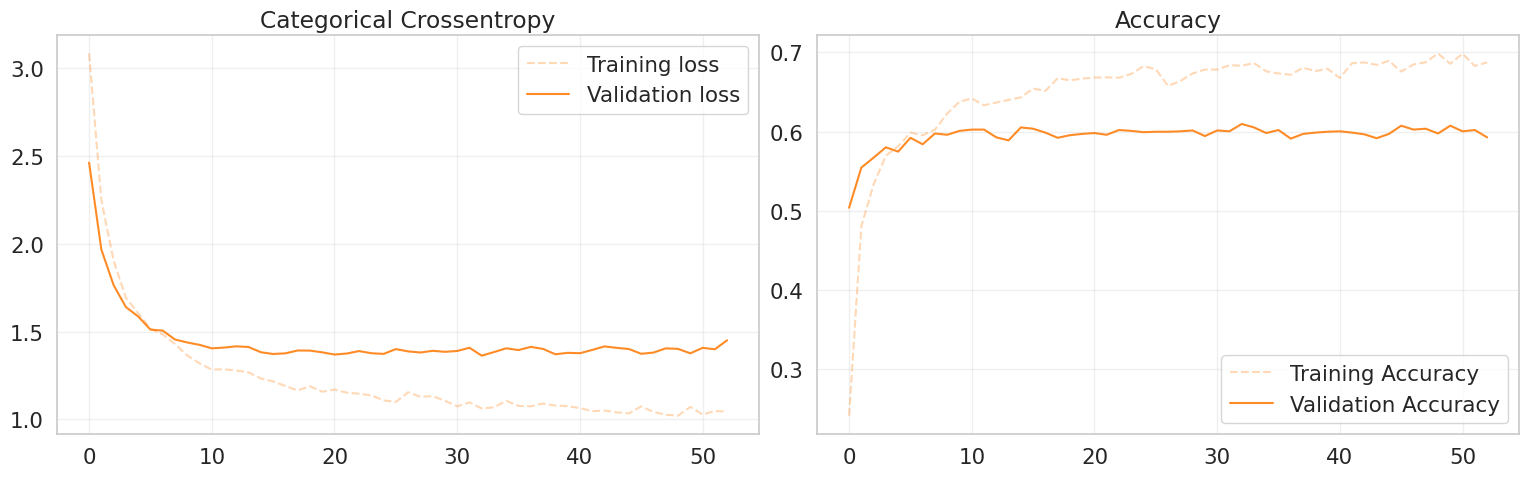

In [24]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(tl_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(tl_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#ff7f0e')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

## 🛠️ **Fine-Tuning**

In [25]:
# Load the transfer learning model
ft_model = EfficientNetB0TransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=False).to(device)
ft_model.load_state_dict(torch.load("models/transfer_learning_model.pt"))

# Unfreeze the last N layers of the backbone
N_LAYERS_TO_UNFREEZE = 20

# Strategy: Freeze everything first, then unfreeze the last few blocks
for param in ft_model.parameters():
    param.requires_grad = False

# The classifier is always trainable
for param in ft_model.backbone.classifier.parameters():
    param.requires_grad = True

# Unfreeze the last 2 blocks of the feature extractor (EfficientNet-B0 has 9 blocks usually)
# Adjust slice index [-2:] to unfreeze more or fewer layers
for block in ft_model.backbone.features[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# Check trainable parameters
trainable_params = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in ft_model.parameters())
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")

Trainable parameters: 1,176,789 / 4,054,945


In [26]:
# Reuse datasets from transfer learning (with ImageNet normalization)
train_ft_ds = PetsDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=True)
val_ft_ds = PetsDataset(X_val, y_val, augmentation=None, normalize_imagenet=True)

train_ft_loader = make_loader(train_ft_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_ft_loader = make_loader(val_ft_ds, BATCH_SIZE, shuffle=False, drop_last=False)

In [27]:
# Setup Training (Lower learning rate for Fine-Tuning)
experiment_name = "fine_tuning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
optimizer = torch.optim.Adam(ft_model.parameters(), lr=1e-4) # 10x smaller LR
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

In [28]:
%%time
# Fine-tune the model
ft_model, ft_history = fit(
    model=ft_model,
    train_loader=train_ft_loader,
    val_loader=val_ft_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_acc = round(max(ft_history['val_acc']) * 100, 2)
print(f'Final validation accuracy: {final_val_acc}%')

Training 200 epochs...
Epoch   1/200 | Train: Loss=1.0773, Acc=0.6883 | Val: Loss=1.2947, Acc=0.6260
Epoch   5/200 | Train: Loss=0.8660, Acc=0.7402 | Val: Loss=1.2334, Acc=0.6429
Epoch  10/200 | Train: Loss=0.7343, Acc=0.7666 | Val: Loss=1.1830, Acc=0.6543
Epoch  15/200 | Train: Loss=0.6449, Acc=0.8046 | Val: Loss=1.1923, Acc=0.6630
Epoch  20/200 | Train: Loss=0.5945, Acc=0.8307 | Val: Loss=1.1600, Acc=0.6701
Epoch  25/200 | Train: Loss=0.5244, Acc=0.8408 | Val: Loss=1.1557, Acc=0.6734
Epoch  30/200 | Train: Loss=0.4754, Acc=0.8524 | Val: Loss=1.1475, Acc=0.6799
Epoch  35/200 | Train: Loss=0.4537, Acc=0.8639 | Val: Loss=1.1531, Acc=0.6794
Epoch  40/200 | Train: Loss=0.4308, Acc=0.8698 | Val: Loss=1.1671, Acc=0.6718
Epoch  45/200 | Train: Loss=0.3864, Acc=0.8848 | Val: Loss=1.1486, Acc=0.6816
Epoch  50/200 | Train: Loss=0.3683, Acc=0.8938 | Val: Loss=1.1648, Acc=0.6816
Epoch  55/200 | Train: Loss=0.3678, Acc=0.8918 | Val: Loss=1.1555, Acc=0.6832
Epoch  60/200 | Train: Loss=0.3061, Acc=0

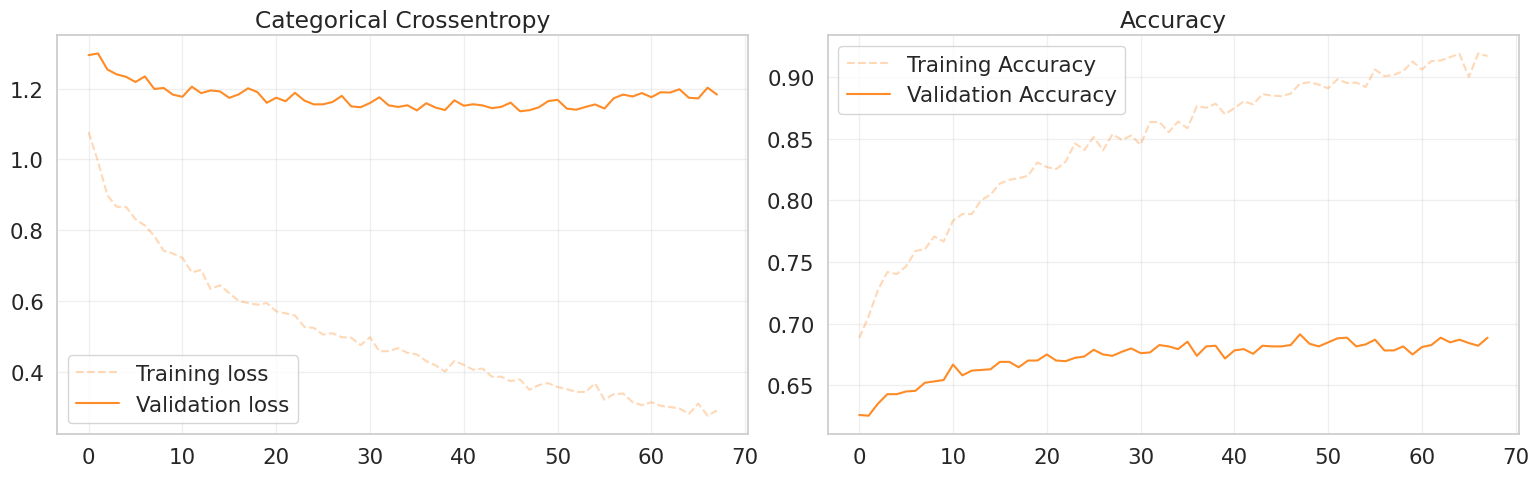

In [29]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(ft_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(ft_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(ft_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#ff7f0e')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [30]:
# Copy TensorBoard logs to accessible location for Colab
!rsync -a $current_dir"/"$logs_dir/ "/content/"$logs_dir/

# Launch TensorBoard interface
%tensorboard --logdir "/content/"$logs_dir

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 26846.

## 🕹️ **Use the Model - Make Inference**

In [31]:
# Load the fine-tuned model for inference
best_model = EfficientNetB0TransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=False).to(device)
best_model.load_state_dict(torch.load("models/fine_tuning_model.pt"))
best_model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [32]:
def crop_square_center(image):
    """Crop image to a square, centered on the middle section."""
    h, w = image.shape[:2]
    crop_size = min(h, w)

    h_offset = (h - crop_size) // 2
    w_offset = (w - crop_size) // 2

    return image[h_offset:h_offset + crop_size, w_offset:w_offset + crop_size]


def preprocess_for_model(image):
    """Preprocess image for model input WITH ImageNet normalization."""
    # Convert to PIL
    image_pil = Image.fromarray((image * 255).astype(np.uint8))

    # Apply transforms with ImageNet normalization
    transform = transforms.Compose([
        transforms.ToImage(),
        transforms.Resize((128, 128), antialias=True),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)  # IMPORTANT!
    ])

    return transform(image_pil)

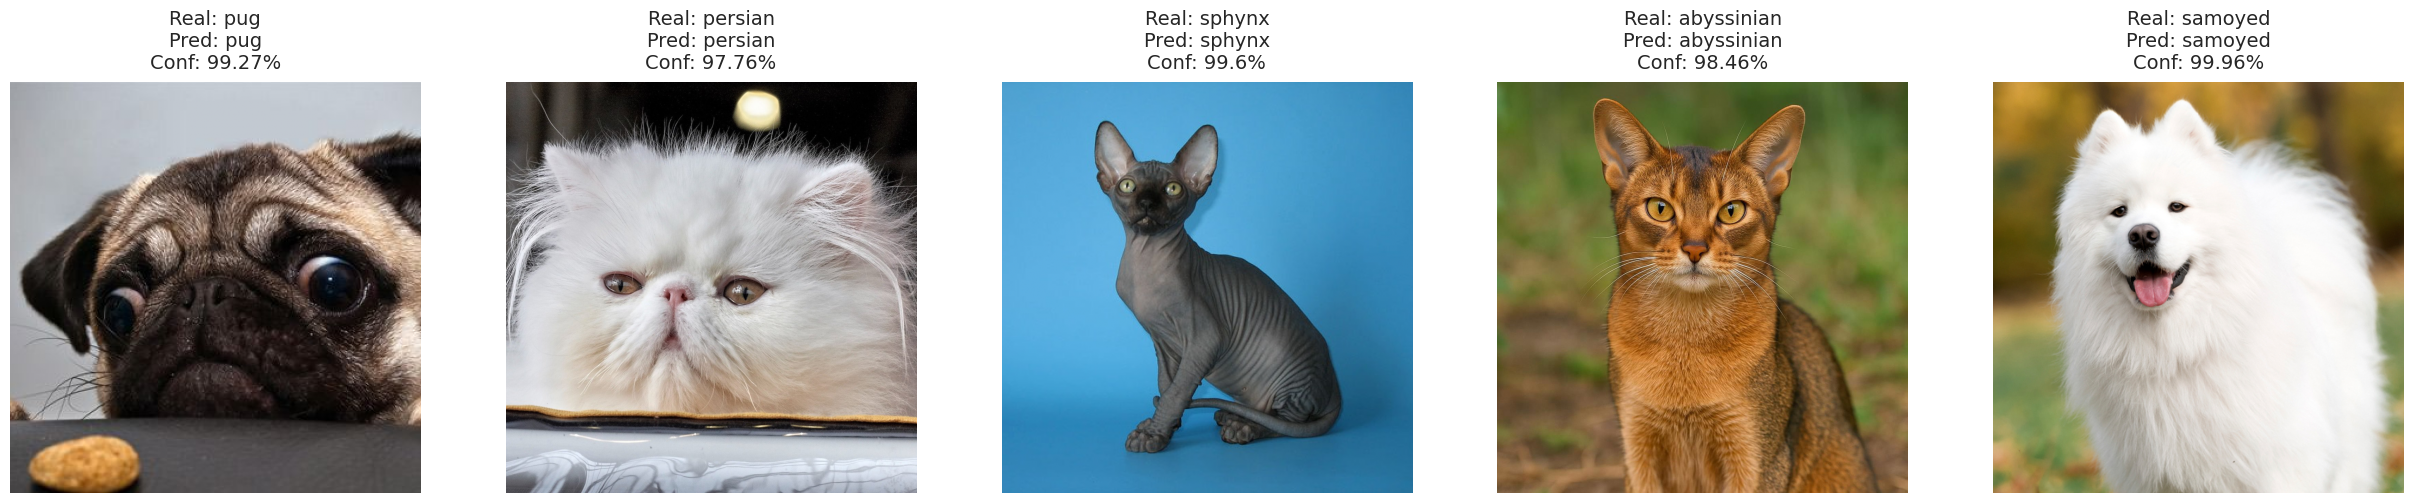

In [33]:
# Dictionary of image URLs and their actual classes
images = {
    'pug': 'https://blog.expodog.com/wp-content/uploads/2020/09/f896a647cfc5346c5b042a6a1e916065.jpg',
    'persian': 'https://images.squarespace-cdn.com/content/v1/5b1cc0f95b409bd4bfc3b316/1687322332437-DOVUPJBJMKQWZ2TRSQA2/sergey-semin-I9cHfDYLT3E-unsplash%281%29.jpg',
    'sphynx': 'https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhcpzLYLRORZQaVRNizLejwVBFp8eIUPS_ZN7Zhw_J54RgeELoupne4wHwxj8o8vr6XXlFtJwTj8QGP7VIpbj_UwTU6bp4Z6lIIM80zkyhKBtN8YHeFQQScopDh0nw8loMvhmxvaurUuP8/s1600/Sphynx_associazione_mammagatta-7.jpg',
    'abyssinian': 'https://cdn.creatures.com/881/88b/da9/0426b.jpeg',
    'samoyed': 'https://images.ctfassets.net/440y9b545yd9/49v1AZmZdiPYkJ4A3vrayj/d7d7db21fed2ef30f5b8e3899633d292/Samoyed850.jpg'
}

# Create a plot for visualizing model predictions
plt.figure(figsize=(25, 5))

with torch.no_grad():
    for i, (true_class, url) in enumerate(images.items(), 1):
        # Load the image from the URL
        response = requests.get(url)
        img_original = np.array(Image.open(BytesIO(response.content))) / 255

        # Crop the image to a square for consistent processing
        img_square = crop_square_center(img_original)

        # Preprocess image for model prediction (with ImageNet normalization)
        img_tensor = preprocess_for_model(img_square).unsqueeze(0).to(device)

        # Predict class
        output = best_model(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        pred_idx = probabilities.argmax(dim=1).item()
        pred_class = class_names[pred_idx]
        confidence = round(100 * probabilities[0, pred_idx].item(), 2)

        # Plot the cropped square image
        plt.subplot(1, 5, i)
        plt.imshow(img_square)
        plt.axis('off')

        # Add title with actual and predicted class info
        plt.title(f'Real: {true_class}\nPred: {pred_class}\nConf: {confidence}%',
                 fontsize=14, pad=10)

# Adjust layout to prevent overlap and display
plt.tight_layout()
plt.show()

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

##### Connect with us:
- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="14"> **LinkedIn:**  [AIRLab Polimi](https://www.linkedin.com/company/airlab-polimi/)
- <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="14"> **Instagram:** [airlab_polimi](https://www.instagram.com/airlab_polimi/)

##### Contributors:
- **Eugenio Lomurno**: eugenio.lomurno@polimi.it
- **Alberto Archetti**: alberto.archetti@polimi.it
- **Roberto Basla**: roberto.basla@polimi.it
- **Carlo Sgaravatti**: carlo.sgaravatti@polimi.it

```
   Copyright 2025 Eugenio Lomurno, Alberto Archetti, Roberto Basla, Carlo Sgaravatti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```